# Rice Panicle Detection — CSE521p-byol-yolo

**Goal.** Self-supervised pretrain the YOLOv12 backbone on your rice images using **BYOL**, then fine-tune a YOLOv12 detector. The notebook also provides quick **representation diagnostics** (k-NN, t-SNE, PCA) and one-click visualizations.

---

## What this notebook does
1. **Data prep**: Convert COCO → YOLO format with progress bars.
2. **BYOL pretraining (SSL)**: 
   - Detect pre-hook to grab FPN maps (P3/P4/P5) → global-pool + concat.  
   - Online/Target networks with EMA, projector/predictor heads.  
   - Cosine LR + warmup, param groups (no WD on norms/bias), grad clipping.
3. **Supervised fine-tune (Detection)**: YOLOv12 with AdamW, cosine LR, EMA, `rect=True`, `cache="ram"`.
4. **Diagnostics (optional)**: k-NN confusion matrix, t-SNE, PCA of BYOL features, sample detection plot.

---

## Dataset
- Root (COCO style):  
  `/kaggle/input/annotated-rice-panicle-image-from-bangladesh`  
- After conversion, YOLO folders are written under:  
  `/kaggle/working/rice_ssl/0_yolo_split/{train,val,test}`

---

## Key toggles (edit in code)
- `MODEL = "yolo12n.yaml"`  – backbone/detector size.
- `SSL_EPOCHS = 5`          – BYOL epochs (sample config; raise for better reps).
- Detector `epochs=5`       – in `det.train(...)`.
- `KNN_VIZ = True`          – enable BYOL k-NN + t-SNE plots.

> **Tip:** If you change epochs or core libs, use **Kaggle → Runtime → Factory reset**, then **Run all** for a clean state.

---

## Outputs
| Artifact | Path |
|---|---|
| BYOL backbone+neck weights | `/kaggle/working/rice_ssl/byol_backbone_with_hooks_y12.pth` |
| YOLO best detector weights | `/kaggle/working/rice_ssl/byol_yolo12n*/weights/best.pt` |
| Plots (detections/diagnostics) | `/kaggle/working/rice_ssl/plots/` |

---

## Repro/Environment
- Seeds set (`42`) for NumPy & PyTorch.
- Notebook installs/uses a recent **ultralytics** build (YOLOv12).
- GPU recommended. If CUDA isn’t available, the code will still run in CPU (slower).

---

## Reading the results
- **Training logs**: BYOL loss (↓), alignment (↓), uniformity (↓) indicate healthier reps.
- **Detector metrics**: focus on **mAP@0.50:0.95**, **mAP@0.50**, **Precision/Recall**.
- **k-NN / t-SNE / PCA**: clusters and accuracy provide a quick sanity check of learned features.

---



In [1]:
!pip install -q -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 8.1 MB/s eta 0:00:00


In [2]:
# ================================================================
# BYOL on YOLOv12 backbone using Detect pre-hook + 1-epoch fine-tune
# Memory-safe (yolo12n, small crops/batch) — same layout as your code
# ================================================================
import json, shutil, yaml, warnings, gc, random, math, copy, os
from pathlib import Path
from PIL import Image
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# ---------------- Paths ----------------

In [3]:
BASE  = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
WORK  = Path("/kaggle/working/rice_ssl")
SPLIT = WORK / "0_yolo_split"
DATA  = WORK / "data_rice.yaml"
SSL_W = WORK / "byol_backbone_with_hooks_y12.pth"   # save neck/backbone weights only
WORK.mkdir(parents=True, exist_ok=True)

# ---------------- Small helpers ----------------

In [4]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]


# ---------------- COCO→YOLO (first run) ----------------

In [5]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x+bw/2)/w, (y+bh/2)/h, bw/w, bh/h

def convert(split, img_dir, ann_json):
    out_im, out_lb = SPLIT / split / "images", SPLIT / split / "labels"
    out_im.mkdir(parents=True, exist_ok=True); out_lb.mkdir(parents=True, exist_ok=True)
    coco = json.load(open(ann_json))
    id2  = {im["id"]: im for im in coco["images"]}

    # write labels with a progress bar
    anns = coco["annotations"]
    for ann in tqdm(anns, desc=f"COCO→YOLO labels [{split}]", leave=False):
        im   = id2[ann["image_id"]]
        yb   = coco2yolo(ann["bbox"], im["width"], im["height"])
        cls  = ann["category_id"] - 1
        with open(out_lb/f"{Path(im['file_name']).stem}.txt","a") as f:
            f.write(f"{cls} "+" ".join(f"{v:.6f}" for v in yb)+"\n")

    # copy images with a progress bar
    for im in tqdm(coco["images"], desc=f"Copy images [{split}]", leave=False):
        src = Path(img_dir)/im["file_name"]
        if src.exists(): shutil.copy(src, out_im/im["file_name"])

if not DATA.exists():
    print("➤ Converting COCO → YOLO …")
    convert("train", BASE/"train", BASE/"train/_annotations.coco.json")
    convert("valid", BASE/"valid", BASE/"valid/_annotations.coco.json")
    convert("test",  BASE/"train", BASE/"train/_annotations.coco.json")  # reuse train as test
    names = [c["name"] for c in sorted(
        json.load(open(BASE/'train/_annotations.coco.json'))["categories"], key=lambda x: x["id"])]
    DATA.write_text(yaml.dump({
        "path":  str(SPLIT),
        "train": "train/images",
        "val":   "valid/images",
        "test":  "test/images",
        "nc":    len(names),
        "names": names
    }))
    print("✓ YOLO split ready.")
else:
    print("YOLO split already exists")

➤ Converting COCO → YOLO …


COCO→YOLO labels [train]:   0%|          | 0/32668 [00:00<?, ?it/s]

Copy images [train]:   0%|          | 0/1754 [00:00<?, ?it/s]

COCO→YOLO labels [valid]:   0%|          | 0/3962 [00:00<?, ?it/s]

Copy images [valid]:   0%|          | 0/219 [00:00<?, ?it/s]

COCO→YOLO labels [test]:   0%|          | 0/32668 [00:00<?, ?it/s]

Copy images [test]:   0%|          | 0/1754 [00:00<?, ?it/s]

✓ YOLO split ready.


# ---------------- Two-view dataset (SSL) ----------------

In [6]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

# ---------------- BYOL loss ----------------

In [7]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

# ---------------- Hook to capture neck outputs (P3,P4,P5) ----------------


In [8]:
class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# ---------------- BYOL pretraining ----------------
# Students must train for at least 50 epochs.

# To retrain with a higher epoch count:
# 1) Set `SSL_EPOCHS = 50` (or your desired value).
# 2) In Kaggle, select “Factory Reset” to clear state.
# 3) Click “Run All” to execute the notebook from a clean start.


In [9]:
MODEL = "yolo12n.yaml"     # YOLOv12 nano config
SSL_EPOCHS, SSL_BATCH = 50, 8 # EPOCHS and BATCH SIZE
m0 = 0.996

if SSL_W.exists():
    print("✓ BYOL backbone cached – skipping pre-train")
else:
    print("\n🔄  BYOL pre-training (1 epoch, hook-based, YOLOv12) …")

    # full models (we'll read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView([SPLIT/"train"/"images", SPLIT/"valid"/"images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # online encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"Epoch {ep+1}/{SSL_EPOCHS} BYOL loss={running/len(dl):.4f}")

    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)


🔄  BYOL pre-training (1 epoch, hook-based, YOLOv12) …
Backbone feature dim: 448


BYOL 1/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 1/50 BYOL loss=1.0832


BYOL 2/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 2/50 BYOL loss=0.9296


BYOL 3/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 3/50 BYOL loss=1.5534


BYOL 4/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 4/50 BYOL loss=2.1806


BYOL 5/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 5/50 BYOL loss=1.6439


BYOL 6/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 6/50 BYOL loss=1.4920


BYOL 7/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 7/50 BYOL loss=1.8043


BYOL 8/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 8/50 BYOL loss=1.5240


BYOL 9/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 9/50 BYOL loss=1.0929


BYOL 10/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 10/50 BYOL loss=1.2523


BYOL 11/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 11/50 BYOL loss=1.4457


BYOL 12/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 12/50 BYOL loss=1.2623


BYOL 13/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 13/50 BYOL loss=1.2366


BYOL 14/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 14/50 BYOL loss=1.5062


BYOL 15/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 15/50 BYOL loss=1.6268


BYOL 16/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 16/50 BYOL loss=1.4833


BYOL 17/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 17/50 BYOL loss=1.4831


BYOL 18/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 18/50 BYOL loss=1.4963


BYOL 19/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 19/50 BYOL loss=1.6019


BYOL 20/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 20/50 BYOL loss=1.7294


BYOL 21/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 21/50 BYOL loss=1.7221


BYOL 22/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 22/50 BYOL loss=1.7296


BYOL 23/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 23/50 BYOL loss=1.6490


BYOL 24/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 24/50 BYOL loss=1.4933


BYOL 25/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 25/50 BYOL loss=1.3667


BYOL 26/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 26/50 BYOL loss=1.2055


BYOL 27/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 27/50 BYOL loss=1.2070


BYOL 28/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 28/50 BYOL loss=1.0714


BYOL 29/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 29/50 BYOL loss=1.0453


BYOL 30/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 30/50 BYOL loss=1.0838


BYOL 31/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 31/50 BYOL loss=1.0671


BYOL 32/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 32/50 BYOL loss=1.0586


BYOL 33/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 33/50 BYOL loss=0.9989


BYOL 34/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 34/50 BYOL loss=1.0310


BYOL 35/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 35/50 BYOL loss=1.0647


BYOL 36/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 36/50 BYOL loss=1.0545


BYOL 37/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 37/50 BYOL loss=1.0259


BYOL 38/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 38/50 BYOL loss=0.9972


BYOL 39/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 39/50 BYOL loss=1.0023


BYOL 40/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 40/50 BYOL loss=0.9568


BYOL 41/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 41/50 BYOL loss=0.9167


BYOL 42/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 42/50 BYOL loss=0.9248


BYOL 43/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 43/50 BYOL loss=0.9377


BYOL 44/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 44/50 BYOL loss=0.9344


BYOL 45/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 45/50 BYOL loss=0.9277


BYOL 46/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 46/50 BYOL loss=0.8949


BYOL 47/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 47/50 BYOL loss=0.8957


BYOL 48/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 48/50 BYOL loss=0.9208


BYOL 49/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 49/50 BYOL loss=0.9307


BYOL 50/50:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 50/50 BYOL loss=0.8944
✓ Saved SSL backbone weights → /kaggle/working/rice_ssl/byol_backbone_with_hooks_y12.pth


# ---------------- Fine-tune YOLO detector ----------------
# Students atleast needs to train for 50 epoch

In [10]:
print("\n🚀 Fine-tuning YOLOv12-n (1 epoch) …")
det = YOLO(MODEL)  # nano to match SSL shapes
# load into all-but-Detect
sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data=str(DATA),
    epochs=2,                # ← set to 1 epoch
    imgsz=640,
    batch=8,
    project=str(WORK),
    name="byol_yolo12n",
    device=0 if device=="cuda" else None,
    verbose=True
)



🚀 Fine-tuning YOLOv12-n (1 epoch) …
Ultralytics 8.3.186 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rice_ssl/data_rice.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=byol_yolo12n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec7acfe4b10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# ---------------- Evaluate + visualize ----------------


📊 Evaluating …
Ultralytics 8.3.186 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2543.1±534.0 MB/s, size: 143.8 KB)
val: Scanning /kaggle/working/rice_ssl/0_yolo_split/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 219/219 376764.8it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 55/55 14.4it/s 3.8s
                   all        219       3962      0.169      0.189      0.101     0.0292
          Rice-Panicle        219       3962      0.169      0.189      0.101     0.0292
Speed: 0.3ms preprocess, 11.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.1693
Recall (mR)      : 0.1888
mAP@0.50         : 0.1006
mAP@0.50:0.95    : 0.0292

Visualising: 377_s

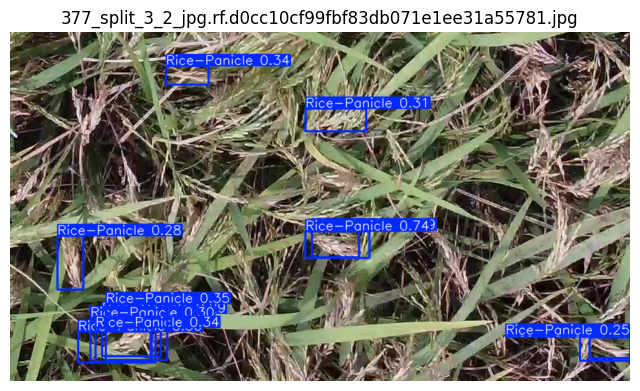

In [11]:

print("\n📊 Evaluating …")
best_pt = WORK/"byol_yolo12n"/"weights"/"best.pt"
model   = YOLO(str(best_pt))
results = model.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else None)

try:
    mp,mr,map50,map5095 = results.mean_results()
    print("\nValidation metrics")
    print(f"Precision (mP)   : {mp:.4f}")
    print(f"Recall (mR)      : {mr:.4f}")
    print(f"mAP@0.50         : {map50:.4f}")
    print(f"mAP@0.50:0.95    : {map5095:.4f}")
except Exception:
    print("Ultralytics API changed; raw results follows:")
    print(results)

cands=list((SPLIT/"test"/"images").glob("*.*")) or list((SPLIT/"valid"/"images").glob("*.*"))
if cands:
    img_path=random.choice(cands)
    print("\nVisualising:", img_path.name)
    pred = model.predict(source=str(img_path), imgsz=640, conf=0.25,
                         device=0 if device=="cuda" else None, verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:,:,::-1]); plt.axis("off"); plt.title(img_path.name); plt.show()
else:
    print("No images found for visualization.")

## ---------------- (Optional) BYOL k-NN sanity-check ----------------


🔎 BYOL k-NN features …


Extract train:   0%|          | 0/28 [00:00<?, ?it/s]

Extract valid:   0%|          | 0/4 [00:00<?, ?it/s]

k-NN accuracy (val): 1.0000


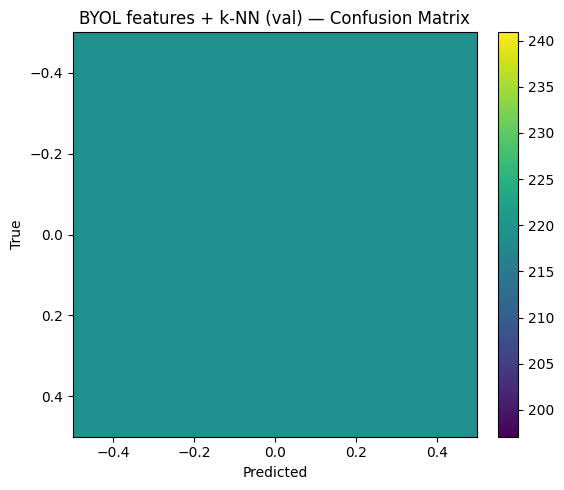

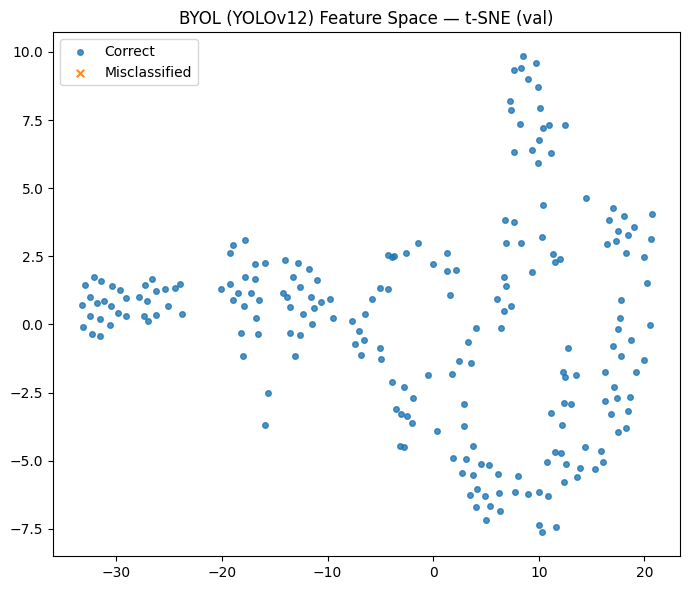


Done ✔


In [12]:
KNN_VIZ = True
if KNN_VIZ:
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import confusion_matrix, accuracy_score
    from sklearn.manifold import TSNE

    def yolo_label_for_image(label_file: Path):
        if not label_file.exists(): return None
        ids=[]
        with open(label_file) as f:
            for line in f:
                parts=line.strip().split()
                if parts:
                    try: ids.append(int(parts[0]))
                    except: pass
        return max(ids, key=ids.count) if ids else None

    def list_images_and_labels(split_dir: Path):
        xs, ys = [], []
        images = sorted((split_dir/"images").glob("*.*"))
        for img_path in images:
            lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
            lab = yolo_label_for_image(lb_path)
            if lab is None: continue
            xs.append(img_path); ys.append(lab)
        return xs, np.array(ys, dtype=np.int64)

    # rebuild backbone+neck with BYOL weights and capture P3/4/5 again
    feat_model = YOLO("yolo12n.yaml").model.to(device)
    _ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
    feat_hook  = DetectInputHook(get_detect_module(feat_model))
    feat_model.eval()

    base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

    class ImgDataset(Dataset):
        def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
        def __len__(self): return len(self.paths)
        def __getitem__(self,i): return self.tfm(Image.open(self.paths[i]).convert("RGB"))

    def extract_feats(paths, bs=64, desc="Extract"):
        ds  = ImgDataset(paths, base_tfm)
        dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
        feats=[]
        for xb in tqdm(dl, desc=desc, leave=False):
            xb = xb.to(device, non_blocking=True)
            with torch.no_grad():
                _ = feat_model(xb)
                h  = global_pool_concat(feat_hook.feats)
            feats.append(h.detach().cpu().numpy())
        return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

    tr_X, tr_y = list_images_and_labels(SPLIT/"train")
    va_X, va_y = list_images_and_labels(SPLIT/"valid")

    if len(tr_X) and len(va_X):
        print("\n🔎 BYOL k-NN features …")
        tr_F = extract_feats(tr_X, bs=64, desc="Extract train")
        va_F = extract_feats(va_X, bs=64, desc="Extract valid")

        if len(tr_F) and len(va_F):
            knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
            knn.fit(tr_F, tr_y)
            va_pred = knn.predict(va_F)
            acc = accuracy_score(va_y, va_pred)
            print(f"k-NN accuracy (val): {acc:.4f}")

            # Confusion matrix
            cm = confusion_matrix(va_y, va_pred)
            plt.figure(figsize=(6,5))
            plt.imshow(cm, interpolation="nearest")
            plt.title("BYOL features + k-NN (val) — Confusion Matrix")
            plt.xlabel("Predicted"); plt.ylabel("True")
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.tight_layout(); plt.show()

            # 2D t-SNE
            if len(va_F) > 10:
                perplex = min(30, max(5, len(va_F)//10))
                tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                            perplexity=perplex, n_iter=1000, random_state=42)
                Z = tsne.fit_transform(va_F)
                mistakes = (va_pred != va_y)
                plt.figure(figsize=(7,6))
                plt.scatter(Z[~mistakes,0], Z[~mistakes,1], s=16, label="Correct", alpha=0.8)
                plt.scatter(Z[mistakes,0],   Z[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
                plt.title("BYOL (YOLOv12) Feature Space — t-SNE (val)")
                plt.legend(); plt.tight_layout(); plt.show()

        feat_hook.close()
        del feat_model
        gc.collect()
        if device=="cuda": torch.cuda.empty_cache()

print("\nDone ✔")

## === BYOL PCA visualization (2D) ===
 - Loads backbone+neck with BYOL weights (SSL_W)
 - Extracts global pooled FPN features for train/val
 - Standardizes → PCA(2) → scatter plot with legend
 - Saves: WORK/plots/pca_train_val.png

➤ Extracting BYOL features (train/val) …


Extract train:   0%|          | 0/28 [00:00<?, ?it/s]

Extract val:   0%|          | 0/4 [00:00<?, ?it/s]

➤ Standardize + PCA …
PCA 2D explained variance: 87.07%


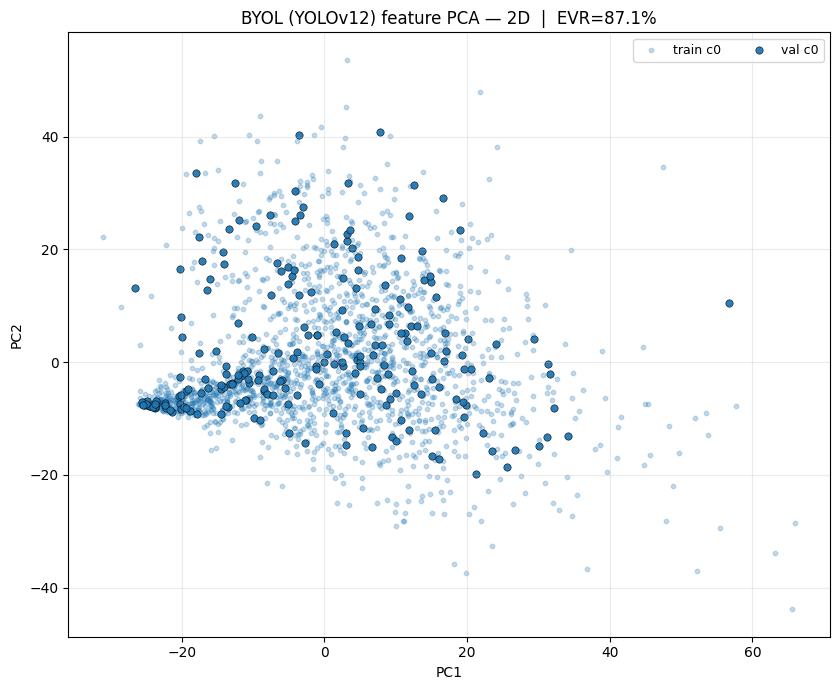

✓ Saved PCA plot → /kaggle/working/rice_ssl/plots/pca_train_val.png


In [13]:
import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from ultralytics import YOLO
import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

PLOTS = (WORK / "plots"); PLOTS.mkdir(parents=True, exist_ok=True)

# --- helpers (safe to re-declare) ---
def imread_rgb(path: Path):
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists(): return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts=line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None: 
            continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])    # [P3,P4,P5]
        return None
    def close(self): self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# --- data lists ---
train_X, train_y = list_images_and_labels(SPLIT/"train")
val_X,   val_y   = list_images_and_labels(SPLIT/"valid")
assert len(train_X) and len(val_X), "No labeled images found for PCA visualization."

# --- feature extractor using BYOL weights ---
feat_model = YOLO("yolo12n.yaml").model.to(device)
_ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
feat_hook  = DetectInputHook(get_detect_module(feat_model))
feat_model.eval()

base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)     # [B, D]
        feats.append(h.detach().cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

print("➤ Extracting BYOL features (train/val) …")
train_F = extract_feats(train_X, bs=64, desc="Extract train")
val_F   = extract_feats(val_X,   bs=64, desc="Extract val")

# cleanup hook
feat_hook.close()
del feat_model
if device=="cuda": torch.cuda.empty_cache()

# --- standardize then PCA (fit on train; transform train+val) ---
print("➤ Standardize + PCA …")
scaler = StandardScaler(with_mean=True, with_std=True)
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)

evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

# --- plot ---
plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")

# train (faint)
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10), label=f"train c{c}")

# val (emphasized)
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"val c{c}")

plt.title(f"BYOL (YOLOv12) feature PCA — 2D  |  EVR={evr*100:.1f}%")
plt.xlabel("PC1"); plt.ylabel("PC2")
# de-duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
out_file = PLOTS/"pca_train_val.png"
plt.savefig(out_file, dpi=160)
plt.show()

print(f"✓ Saved PCA plot → {out_file}")
